#### Imports

In [1]:
import pandas as pd
import pickle
import sklearn
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import gensim
from gensim.models import Word2Vec, KeyedVectors
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import sklearn
from sklearn.preprocessing import OneHotEncoder
import tensorflow.keras as keras
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D,MaxPooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D as Conv1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.metrics import roc_curve, auc, confusion_matrix,accuracy_score,precision_score
import seaborn as sns
import matplotlib.pyplot as plt

#### Read dataset

In [2]:
dset = pd.read_pickle('restaurants_places.pickle')

In [3]:
# dset= dset.head(100000)
dset

,gPlusPlaceId,rating,reviewerName,reviewText,categories,unixReviewTime,reviewTime,gPlusUserId,name,price,...,hours,phone,closed,gps,lat,long,open_days,Dinner,Lunch,Breakfast
0,112181651134020562716,5.0,jason wagner,stopped dinner mahi mahi special fantastic ser...,"[european restaurant, italian restaurant]",1.35058e+09,"Oct 18, 2012",100000196778399872657,Pasquales Trattoria,None,...,"[[Monday, [['Closed']]], [Tuesday, [['11:30 am...",(905) 338-9090,False,"[43.440331, -79.672851]",43.440331,-79.672851,6.0,1.0,0.0,0.0
1,116784654951669476004,4.0,betsi h,parents stopped dinner hospital procedure rest...,[restaurant],1.39149e+09,"Feb 3, 2014",100000217241208417605,Ming's Asian Bistro,None,...,None,(906) 482-9888,False,"[47.11239, -88.585033]",47.112390,-88.585033,NaN,NaN,NaN,NaN
2,116784654951669476004,5.0,koryne marzicola,amazing delishious definedly recommend mings a...,[restaurant],1.34869e+09,"Sep 26, 2012",104217571457797699036,Ming's Asian Bistro,None,...,None,(906) 482-9888,False,"[47.11239, -88.585033]",47.112390,-88.585033,NaN,NaN,NaN,NaN
3,109391653021436219474,5.0,heather goldsworthy,best coffee collingwood,[cafe],1.37899e+09,"Sep 12, 2013",100000427343266187570,Espresso Post,None,...,None,(705) 446-1740,False,"[44.499252, -80.216587]",44.499252,-80.216587,NaN,NaN,NaN,NaN
4,109391653021436219474,5.0,nicholas clayton,located old post office outlet historical pedi...,[cafe],1.36761e+09,"May 3, 2013",104975196938413074237,Espresso Post,None,...,None,(705) 446-1740,False,"[44.499252, -80.216587]",44.499252,-80.216587,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115125,100517859306829739433,5.0,joel bouchard,came wild guess last night trip kitchener turn...,[bar & grill],1.37634e+09,"Aug 12, 2013",106225026430651908241,Moxie's Grill & Bar Kitchener-Waterloo,None,...,"[[Monday, [['11:00 am--12:00 am']]], [Tuesday,...",(519) 208-4488,False,"[43.419861, -80.441227]",43.419861,-80.441227,7.0,1.0,1.0,0.0
115126,105079829670069980439,5.0,craigs lister,best latin restaurant food state food always f...,[restaurant],1.31904e+09,"Oct 19, 2011",106225339835084588441,Macorisano Serie 23,None,...,None,(781) 592-5823,False,"[42.464978, -70.948156]",42.464978,-70.948156,NaN,NaN,NaN,NaN
115127,110494876430584380792,3.0,craigs lister,n t see big deal ordered take out times ok pro...,"[chinese restaurant, asian restaurant, pan-asi...",1.31973e+09,"Oct 27, 2011",106225339835084588441,Billy Tse,$$,...,"[[Monday, [['11:00 am--12:00 am']]], [Tuesday,...",(781) 286-2882,False,"[42.418534, -70.993968]",42.418534,-70.993968,7.0,1.0,1.0,0.0
115128,104051761369663560291,4.0,kellygirllashes,visiting michigan yesterday introduced place g...,"[restaurant, steak house]",1.37745e+09,"Aug 25, 2013",106226607739575020646,Big John Steak & Onion,None,...,"[[Monday, [['7:00 am--10:00 pm']]], [Tuesday, ...",(810) 232-9322,False,"[43.002459, -83.743579]",43.002459,-83.743579,7.0,1.0,0.0,1.0


In [4]:
dset['reviewText'].apply(lambda x: len(x.split(" "))).mean() # mean -> 24 words, max -> 417 words, min -> 1 word

23.805107270042562

In [5]:
dset.head()

,gPlusPlaceId,rating,reviewerName,reviewText,categories,unixReviewTime,reviewTime,gPlusUserId,name,price,...,hours,phone,closed,gps,lat,long,open_days,Dinner,Lunch,Breakfast
0,112181651134020562716,5.0,jason wagner,stopped dinner mahi mahi special fantastic ser...,"[european restaurant, italian restaurant]",1.35058e+09,"Oct 18, 2012",100000196778399872657,Pasquales Trattoria,None,...,"[[Monday, [['Closed']]], [Tuesday, [['11:30 am...",(905) 338-9090,False,"[43.440331, -79.672851]",43.440331,-79.672851,6.0,1.0,0.0,0.0
1,116784654951669476004,4.0,betsi h,parents stopped dinner hospital procedure rest...,[restaurant],1.39149e+09,"Feb 3, 2014",100000217241208417605,Ming's Asian Bistro,None,...,None,(906) 482-9888,False,"[47.11239, -88.585033]",47.112390,-88.585033,NaN,NaN,NaN,NaN
2,116784654951669476004,5.0,koryne marzicola,amazing delishious definedly recommend mings a...,[restaurant],1.34869e+09,"Sep 26, 2012",104217571457797699036,Ming's Asian Bistro,None,...,None,(906) 482-9888,False,"[47.11239, -88.585033]",47.112390,-88.585033,NaN,NaN,NaN,NaN
3,109391653021436219474,5.0,heather goldsworthy,best coffee collingwood,[cafe],1.37899e+09,"Sep 12, 2013",100000427343266187570,Espresso Post,None,...,None,(705) 446-1740,False,"[44.499252, -80.216587]",44.499252,-80.216587,NaN,NaN,NaN,NaN
4,109391653021436219474,5.0,nicholas clayton,located old post office outlet historical pedi...,[cafe],1.36761e+09,"May 3, 2013",104975196938413074237,Espresso Post,None,...,None,(705) 446-1740,False,"[44.499252, -80.216587]",44.499252,-80.216587,NaN,NaN,NaN,NaN


In [6]:
dset = dset[dset['rating']!=0]

#### Word2Vec and preprocessing for model

In [7]:
vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=300000) # each vector is of length 300

In [8]:
vec_model['good'].shape # each vector is 300 dims

(300,)

In [9]:
# convert each review into list of word vectors
dset_vector = []
for idx, row in dset.iterrows():
    sentence_vec = []
    sentence = row['reviewText']
    sentence = word_tokenize(sentence)
    for word in sentence:
        try:
            sentence_vec.append(vec_model[word])
        except Exception as e:
            pass
    dset_vector.append(sentence_vec)

In [10]:
temp_dset_vector = dset_vector # shape (115129, n, 300) -> n is the length of the review

In [11]:
zero_pad = np.zeros((300, ))
trimmed_dset_vector = []
trim_length = 24
for item in dset_vector:
    if len(item)>trim_length:
        trimmed_dset_vector.append(np.array(item[:trim_length]))
    else:
        len_zero_pads = trim_length - len(item)
        for i in range(len_zero_pads):
            item.append(zero_pad)
        trimmed_dset_vector.append(np.array(item))

In [12]:
trimmed_dset_vector = np.array(trimmed_dset_vector) # shape -> (115130, trim_length, 300)

In [13]:
ratings = np.array(dset['rating'])
enc = OneHotEncoder()
# one-hot encode the ratings
ratings = enc.fit_transform(ratings.reshape(-1, 1)).toarray()

In [14]:
trimmed_dset_vector.shape

(115130, 24, 300)

In [15]:
ratings.shape

(115130, 5)

#### Create train and test set

In [16]:
split = 0.8
train_len = int(split * len(ratings))
train_reviews = trimmed_dset_vector[:train_len]
train_ratings = ratings[:train_len]
test_reviews = trimmed_dset_vector[train_len:]
test_ratings = ratings[train_len:]

#### Model

In [41]:
inputs = tf.keras.Input(shape=(24, 300), dtype="float32")
x = layers.Dropout(0.3)(inputs)
x = layers.Conv1D(128, 1, paddin g="valid", activation="relu", strides=1)(x)
x = layers.Conv1D(64, 3, padding="valid", activation="relu", strides=1)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation="softmax", name="predictions")(x)
model = tf.keras.Model(inputs, predictions)

In [42]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

label_counts = train_ratings.sum(axis = 0)
train_size = len(train_ratings)

class_weight = {0: train_size / ( 5 * label_counts[0]),  #rating 1
                1: train_size / ( 5 * label_counts[1]),
                2: train_size / ( 5 * label_counts[2]),
                3: train_size / ( 5 * label_counts[3]),
                4: train_size / ( 5 * label_counts[4])}  #rating 5

class_weight

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 24, 300)]         0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 24, 300)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 24, 128)           38528     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 22, 64)            24640     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0   

{0: 3.0609504818876703,
 1: 2.275577516985794,
 2: 1.565595784463709,
 3: 0.7685901447824092,
 4: 0.4359127265843154}

In [43]:
history = model.fit(train_reviews, train_ratings, validation_split=0.2, epochs=10,batch_size=128, class_weight=class_weight)

Epoch 1/10
576/576 [==============================] - 10s 17ms/step - loss: 1.3286 - accuracy: 0.4110 - val_loss: 1.1330 - val_accuracy: 0.4907
Epoch 2/10
576/576 [==============================] - 10s 17ms/step - loss: 1.2069 - accuracy: 0.4904 - val_loss: 1.0547 - val_accuracy: 0.5287
Epoch 3/10
576/576 [==============================] - 9s 16ms/step - loss: 1.1790 - accuracy: 0.5041 - val_loss: 1.0748 - val_accuracy: 0.5175
Epoch 4/10
576/576 [==============================] - 9s 16ms/step - loss: 1.1619 - accuracy: 0.5108 - val_loss: 1.1404 - val_accuracy: 0.4945
Epoch 5/10
576/576 [==============================] - 9s 16ms/step - loss: 1.1462 - accuracy: 0.5178 - val_loss: 1.0876 - val_accuracy: 0.5049
Epoch 6/10
576/576 [==============================] - 9s 16ms/step - loss: 1.1341 - accuracy: 0.5257 - val_loss: 1.0663 - val_accuracy: 0.5182
Epoch 7/10
576/576 [==============================] - 9s 16ms/step - loss: 1.1235 - accuracy: 0.5283 - val_loss: 1.0604 - val_accuracy: 0.52

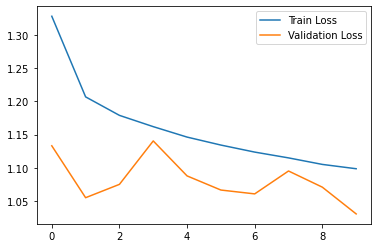

In [44]:
plt.plot(history.history['loss'],label = "Train Loss")
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.legend()
plt.show()

In [45]:
score, acc = model.evaluate(test_reviews, test_ratings)

720/720 [==============================] - 1s 2ms/step - loss: 1.0312 - accuracy: 0.5426


In [33]:
train_ratings.sum(axis = 0 )

array([ 6018.,  8095., 11766., 23967., 42258.])

In [34]:
prob_test = np.round(model.predict(test_reviews))
prob_test = pd.DataFrame(data = prob_test, columns = ['1', '2', '3','4','5'])
prob_test = prob_test.idxmax(axis = 1)

test_ratings_df = pd.DataFrame(data = test_ratings, columns = ['1', '2', '3','4','5'])
y_test_label = test_ratings_df.idxmax(axis = 1)

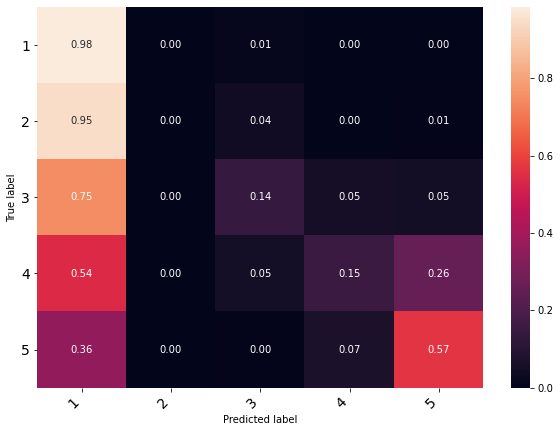

In [35]:
# Calculate confusion matrix
confusion_matrix_dnn = confusion_matrix(y_true = y_test_label, 
                    y_pred = prob_test)

# Turn matrix to percentages
confusion_matrix_dnn = confusion_matrix_dnn.astype('float') / confusion_matrix_dnn.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_dnn, index=['1', '2', '3','4','5'],
         columns=['1', '2', '3','4','5'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

In [26]:
accuracy_score(y_test_label,prob_test)*100

35.52940154607835